In [147]:
import geopandas as gdp
import pandas as pd
import numpy as np
import re
from shapely.geometry import Point
from pathlib import Path
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.dates as mdates
from collections import Counter


DATA_DIR = 'Data/'

# Loading the Data

In [148]:
def get_offsets(header_lines):
    # Capture important information from the header
    offset_pattern = re.compile(r"#\s*(\*?)\s*offset\s+\d+:?\s+([-\d.]+)\s+\+/\-\s+([-\d.]+)\s+mm.*?\((\d{4}-\d{2}-\d{2}).*?\)")
    ps_decay_pattern = re.compile(r'#!?\s*ps decay\s+\d:\s*(-?\d+\.\d+)\s+\+/-\s+(\d+\.\d+)\s+mm\s+\((\d{4}-\d{2}-\d{2})\s+\[(\d{4}\.\d+)\]\);\s*tau:\s*(\d+)\s+days')
    component_pattern = re.compile(r"#\s+([neu])\s+component")

    components = {'n': {'offsets': [], 'ps_decays': []}, 'e': {'offsets': [], 'ps_decays': []}, 'u': {'offsets': [], 'ps_decays': []}}
    current_component = None

    for line in header_lines:
        comp_match = component_pattern.match(line)
        if comp_match:
            current_component = comp_match.group(1)
            continue

        # Check for offset
        offset_match = offset_pattern.match(line)
        if offset_match and current_component:
            coseismic = bool(offset_match.group(1))  # True if * present, meaning coseismic
            offset_value = float(offset_match.group(2))
            offset_error = float(offset_match.group(3))
            offset_date = offset_match.group(4)
            components[current_component]['offsets'].append({
                'value': offset_value,
                'error': offset_error,
                'date': offset_date,
                'coseismic': coseismic
            })

        # Check for postseismic decay
        ps_decay_match = ps_decay_pattern.match(line)
        if ps_decay_match and current_component:
            decay_value = float(ps_decay_match.group(1))
            decay_error = float(ps_decay_match.group(2))
            decay_date = ps_decay_match.group(3)
            tau = int(ps_decay_match.group(5))
            # Determine decay type based on the presence of '!'
            decay_type = 'logarithmic' if '!' in line else 'exponential'
            components[current_component]['ps_decays'].append({
                'value': decay_value,
                'error': decay_error,
                'tau': tau,
                'date': decay_date,
                'type': decay_type
            })

    return components

def read_file(filename):
    
    with open(DATA_DIR+filename, 'r') as file:
        lines = file.readlines()

    header_lines = [line for line in lines if line.startswith('#')]
    if header_lines:
        column_names = re.split(r'\s{2,}', header_lines[-1].lstrip('#').strip())
    else:
        column_names = []
        
    data_lines = []
    for line in lines:
        if not line.startswith('#'):
            parts = line.strip().split()
            # Check if the number of parts matches the expected number of columns
            if len(parts) < len(column_names):
                # Add None for missing values
                parts.extend([None] * (len(column_names) - len(parts)))
            data_lines.append(parts)

    data = pd.DataFrame(data_lines)
    data.columns = column_names
    
    # Extracts latitude, longitude and height
    pattern = r'Latitude\(DD\)\s*:\s*(-?\d+\.\d+)|East Longitude\(DD\)\s*:\s*(-?\d+\.\d+)|Height\s*\(M\)\s*:\s*(-?\d+\.\d+)'
    #referece_pattern = r'Reference_X\s*:\s*(-?\d+\.\d+)|Reference_Y\s*:\s*(-?\d+\.\d+)|Reference_Z\s*:\s*(-?\d+\.\d+)'
    matches = re.findall(pattern, ' '.join(header_lines))
    geom = Point(float(matches[1][1]), float(matches[0][0]))
    
    offsets = get_offsets(header_lines)

    data['Date'] = pd.to_datetime(data['Yr'].astype(str) + data['DayOfYr'].astype(str), format='%Y%j')
    data.set_index('Date', inplace=True)
    data.drop(['Dec Yr', 'Yr', 'DayOfYr', 'Chi-Squared'], axis=1, inplace=True)
    cols = ['N', 'E', 'U', 'N sig', 'E sig', 'U sig', 'CorrNE', 'CorrNU', 'CorrEU']
    data[cols] = data[cols].astype(float)
    
    data.name = filename.replace("RawTrend.neu", "")
    data.attrs['geometry'] = geom
    data.attrs['height'] = float(matches[2][2])
    data.attrs['offsets'] = offsets
    
    return data

In [149]:
def organize_files():
    gdfs = []
    dir = Path(DATA_DIR)
    for file_path in dir.iterdir():
        if file_path.is_file():
            gdfs.append(read_file(file_path.name))
    return gdfs

In [150]:
dfs = organize_files()

# First Plots

In [151]:
def get_geometries(dfs):
    return gdp.GeoDataFrame(geometry=[df.attrs['geometry'] for df in dfs])

In [152]:
def plot_stations(dfs):
    gdf = get_geometries(dfs)
    gdf.set_crs(epsg=4326, inplace=True)
    gdf.to_crs(epsg=3857, inplace=True)
    ax = gdf.plot(marker='o', color='red', markersize=10, figsize=(20, 20))
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    plt.show()

In [153]:
def plot_logarithmic_decay(ax, decay, tau, value):
    """
    Plot logarithmic decay starting from the decay's date.
    """
    decay_start = pd.to_datetime(decay['date'])
    time_range = pd.date_range(decay_start, periods=100, freq='D')
    time_since_start = (time_range - decay_start).days
    
    # Logarithmic decay curve
    decay_curve = value * np.log(1 + time_since_start / tau)
    
    line, = ax.plot(time_range, decay_curve, linestyle='-', color='y')
    return line

def plot_exponential_decay(ax, decay, tau, value):
    """
    Plot exponential decay starting from the decay's date.
    """
    decay_start = pd.to_datetime(decay['date'])
    time_range = pd.date_range(decay_start, periods=100, freq='D')
    time_since_start = (time_range - decay_start).days
    
    # Exponential decay curve
    decay_curve = value * np.exp(-time_since_start / tau)
    
    line, = ax.plot(time_range, decay_curve, linestyle='--', color='g')
    return line


In [154]:
def plot_time_series(df_org, cols, titles, offset_date=None, zoom_days=300, xlabel='Date', ylabel='Data', 
                     second_ylabel='Secondary Data', error_scale=1, plot_decays=True):
    
    # Create subplots
    fig, axs = plt.subplots(1, len(cols), figsize=(15, 5), sharey=False)
    
    df = df_org.copy()
    df.name = df_org.name

    # Convert original data from meters to millimeters
    for col in cols:
        if col not in ['CorrNE', 'CorrNU', 'CorrEU']:
            df[col] *= 1000

    # If an offset_date is provided, zoom in around it; otherwise, plot the whole range
    if offset_date:
        offset_date = pd.to_datetime(offset_date)
        start_date = offset_date - pd.Timedelta(days=zoom_days)
        end_date = offset_date + pd.Timedelta(days=zoom_days)
        
        # Filter the dataframe to focus only on the relevant time window
        df_zoomed = df.loc[(df.index >= start_date) & (df.index <= end_date)]
    else:
        # No offset date, use the entire time range
        df_zoomed = df

    # Plotting the main time-series data
    df_zoomed[cols].plot(ax=axs, subplots=True, legend=False, style='o', ylabel=ylabel, xlabel=xlabel, color='b', label='_nolegend_')

    # Set titles for each subplot
    for ind, ax in enumerate(axs): 
        ax.set_title(f'Station: {df.name}\n{titles[ind]}')

        # Rotate x-axis labels for better readability
        for label in ax.get_xticklabels():
            label.set_rotation(45)

        # Limit the number of x-ticks to avoid crowding
        if offset_date:
            ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
        else:
            ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))

        # Set x-axis format for dates
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d' if offset_date else '%Y'))

    components = ['n', 'e', 'u']
    offsets_data = df.attrs['offsets']

    # Create secondary y-axes for offsets
    secondary_y_axes = [ax.twinx() for ax in axs]

    handles = []  # To store handles for legend
    labels = []   # To store unique labels

    for i, component in enumerate(components):
        # Get the offsets and decays for the current component
        comp_offsets = offsets_data[component]['offsets']
        comp_decays = offsets_data[component].get('ps_decays', [])

        # Plot offsets with potentially scaled error bars
        for offset in comp_offsets:
            linestyle = '-' if offset.get('coseismic', False) else '--'
            color = 'r' if linestyle == '-' else 'orange'
            label = ('Coseismic Offset' if offset.get('coseismic', False) else 'Non-coseismic Offset')
            marker = 'o' if linestyle == '-' else 's'
            
            secondary_y_axes[i].errorbar(
                pd.to_datetime(offset['date']),
                offset['value'],
                yerr=offset['error'] * error_scale,
                fmt=marker,
                markersize=10,
                capsize=5,
                capthick=2,
                color=color,
                label=label
            )
            
            # Add label and handle only if it's new
            if label not in labels:
                handles.append(plt.Line2D([0], [0], marker=marker, color='w', label=label, markerfacecolor=color))
                labels.append(label)

        # Plot decays as curves over time if enabled
        if plot_decays:
            for decay in comp_decays:
                decay_type = decay['type']
                tau = decay['tau']
                value = decay['value']

                if decay_type == 'logarithmic':
                    line = plot_logarithmic_decay(axs[i], decay, tau, value)
                    if 'Logarithmic Decay' not in labels:
                        handles.append(line) 
                        labels.append('Logarithmic Decay')

                elif decay_type == 'exponential':
                    line = plot_exponential_decay(axs[i], decay, tau, value)
                    if 'Exponential Decay' not in labels:
                        handles.append(line)
                        labels.append('Exponential Decay')

        if i == 0:
            axs[i].set_ylabel(ylabel)
        else:
            axs[i].set_ylabel('')

        if i == len(cols)-1 and second_ylabel:
            secondary_y_axes[i].set_ylabel(second_ylabel)

        # Set x-axis limits if zooming around the offset
        if offset_date:
            axs[i].set_xlim(start_date, end_date)

    if handles:
        axs[0].legend(handles, labels, loc='best')

    plt.tight_layout()
    plt.show()



Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



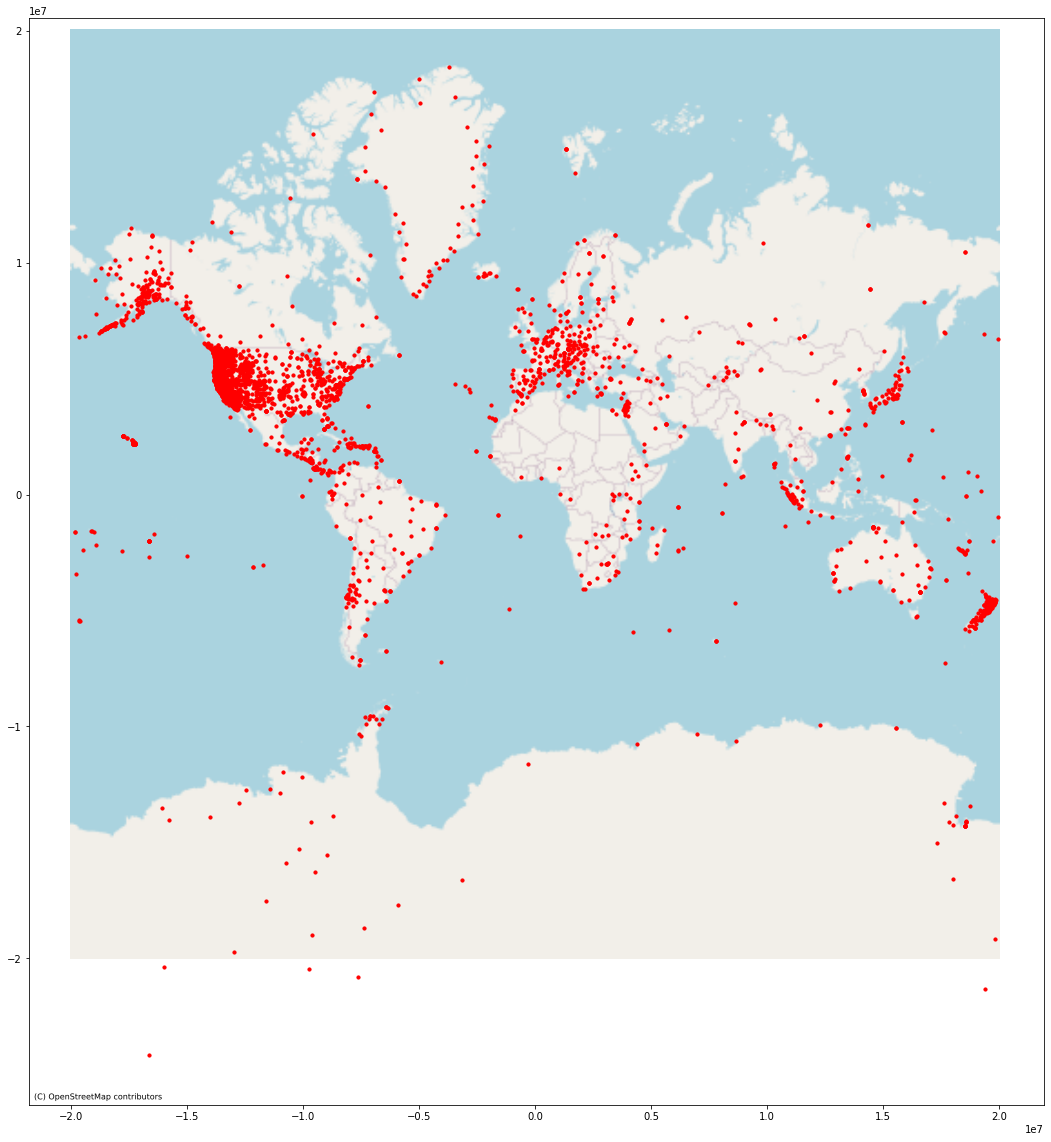

In [155]:
plot_stations(dfs)

c:\Users\nteut\anaconda3\envs\proj\lib\site-packages\matplotlib\cbook\__init__.py:1327: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
c:\Users\nteut\anaconda3\envs\proj\lib\site-packages\matplotlib\axes\_base.py:504: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


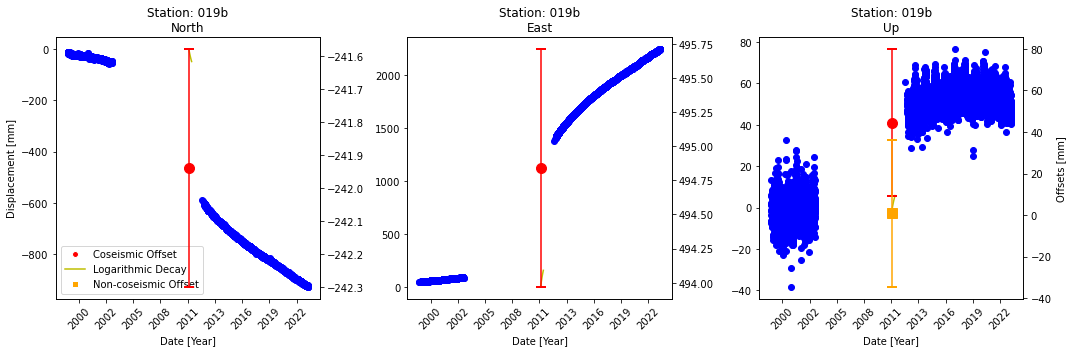

c:\Users\nteut\anaconda3\envs\proj\lib\site-packages\matplotlib\cbook\__init__.py:1327: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
c:\Users\nteut\anaconda3\envs\proj\lib\site-packages\matplotlib\axes\_base.py:504: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


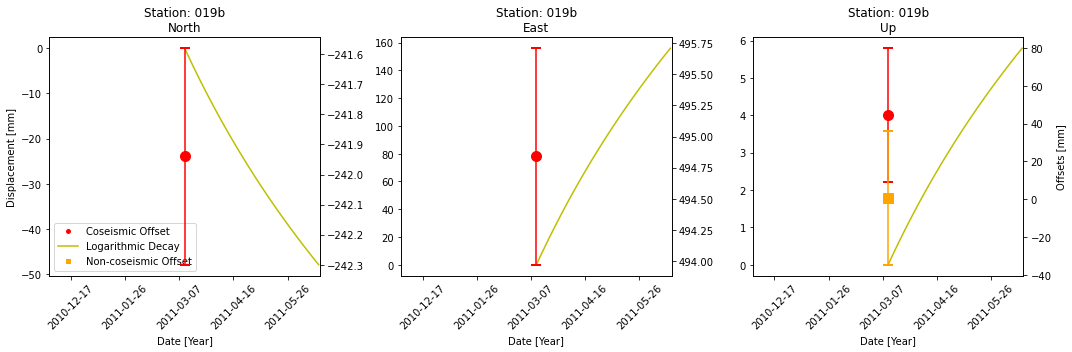

In [156]:
df = dfs[51]
plot_time_series(df, ['N', 'E', 'U'], titles=['North', 'East', 'Up'], ylabel='Displacement [mm]', xlabel='Date [Year]', second_ylabel='Offsets [mm]')
plot_time_series(df, ['N', 'E', 'U'], titles=['North', 'East', 'Up'], ylabel='Displacement [mm]', xlabel='Date [Year]', second_ylabel='Offsets [mm]', offset_date=df.attrs['offsets']['n']['offsets'][0]['date'], zoom_days=100, plot_decays=True)

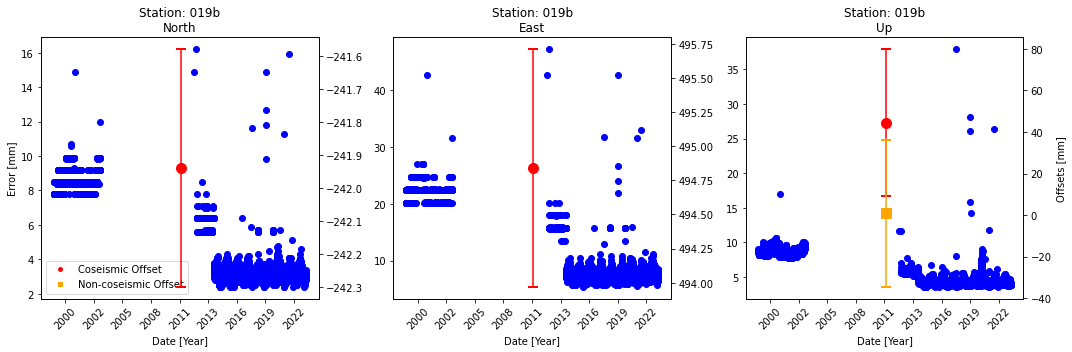

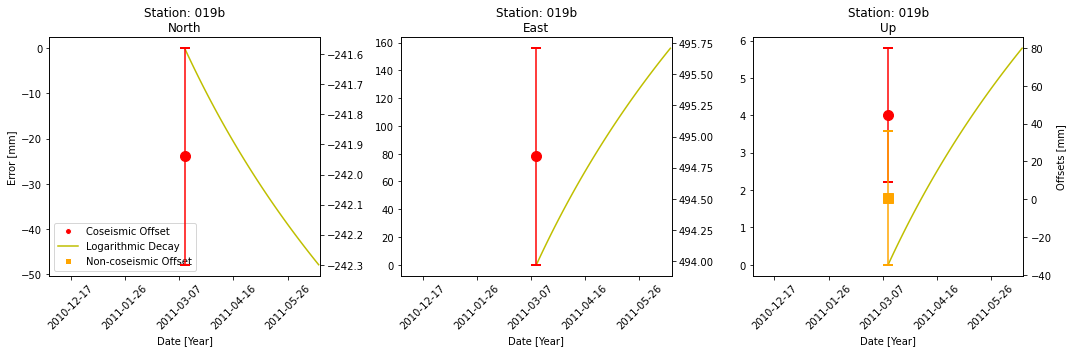

In [157]:
plot_time_series(df, ['N sig', 'E sig', 'U sig'], titles=['North', 'East', 'Up'], ylabel='Error [mm]', xlabel='Date [Year]', second_ylabel= 'Offsets [mm]', plot_decays=False)
plot_time_series(df, ['N sig', 'E sig', 'U sig'], titles=['North', 'East', 'Up'], ylabel='Error [mm]', xlabel='Date [Year]', second_ylabel= 'Offsets [mm]', offset_date=df.attrs['offsets']['n']['offsets'][0]['date'], zoom_days=100, plot_decays=True)

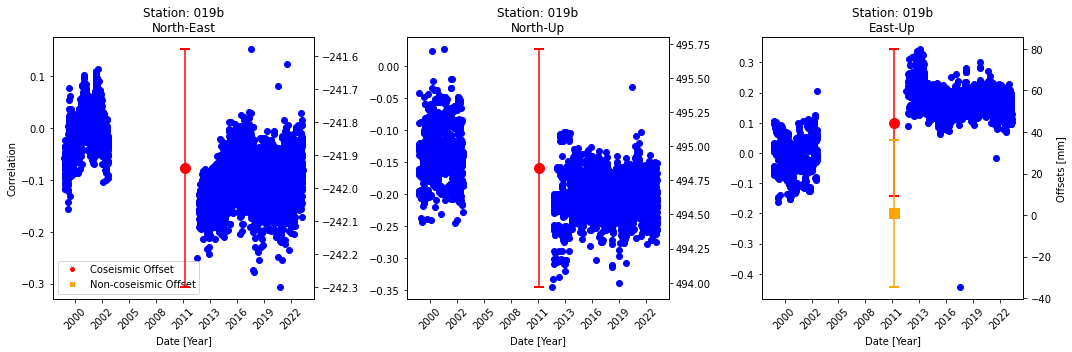

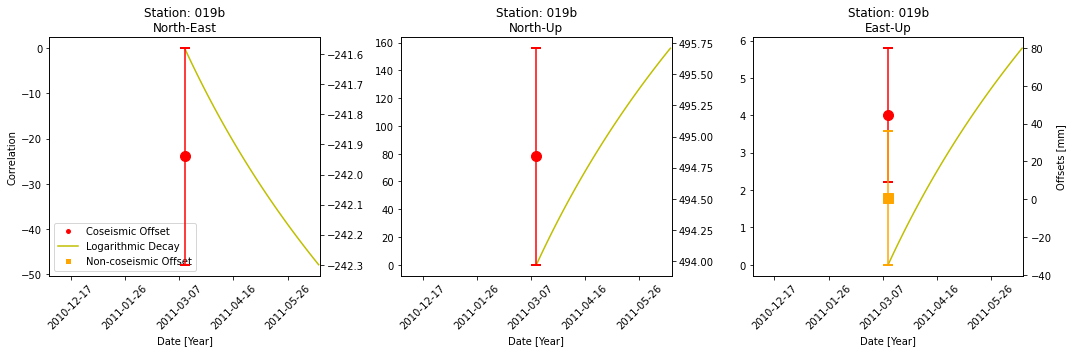

In [158]:
plot_time_series(df, ['CorrNE', 'CorrNU', 'CorrEU'], titles=['North-East', 'North-Up', 'East-Up'], ylabel='Correlation', xlabel='Date [Year]', second_ylabel='Offsets [mm]', plot_decays=False)
plot_time_series(df, ['CorrNE', 'CorrNU', 'CorrEU'], titles=['North-East', 'North-Up', 'East-Up'], ylabel='Correlation', xlabel='Date [Year]', second_ylabel='Offsets [mm]', offset_date=df.attrs['offsets']['n']['offsets'][0]['date'], zoom_days=100, plot_decays=True)

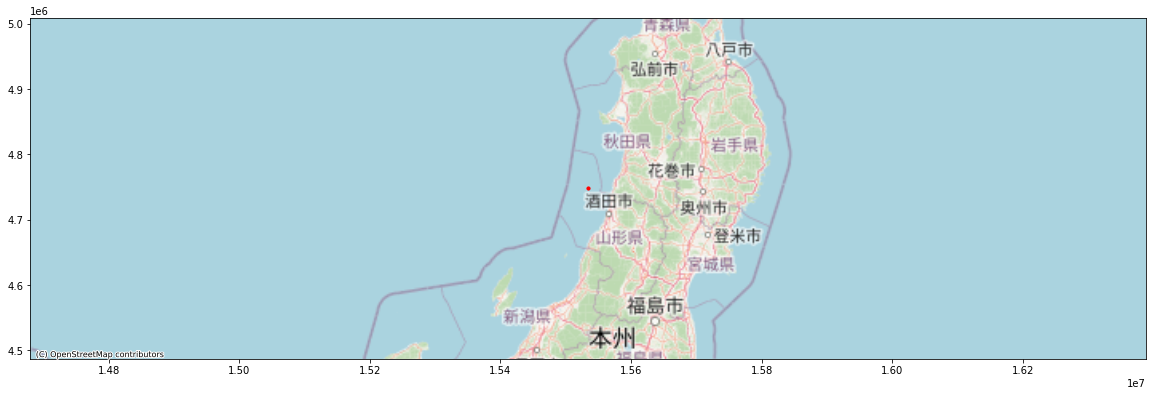

In [159]:
plot_stations([df])

# First Statistics

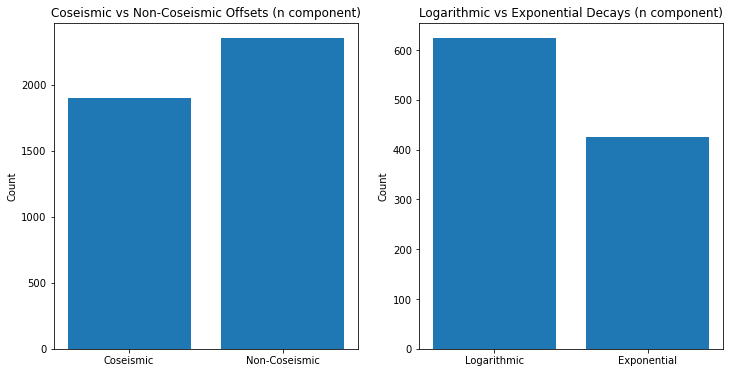

In [160]:
component = 'n'
offsets_data = []
ps_decays_data = []
coseismic_offsets = 0
non_coseismic_offsets = 0
log_decays = 0
exp_decays = 0

for df in dfs:
    for offset in df.attrs['offsets'][component]['offsets']:
        if offset['coseismic']:
            coseismic_offsets += 1
        else:
            non_coseismic_offsets += 1
        offsets_data.append(offset['value'])
    
    for decay in df.attrs['offsets'][component]['ps_decays']:
        if decay['type'] == 'logarithmic':
            log_decays += 1
        else:
            exp_decays += 1
        ps_decays_data.append(decay['value'])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].bar(['Coseismic', 'Non-Coseismic'], [coseismic_offsets, non_coseismic_offsets])
axs[0].set_title(f'Coseismic vs Non-Coseismic Offsets ({component} component)')
axs[0].set_ylabel('Count')

axs[1].bar(['Logarithmic', 'Exponential'], [log_decays, exp_decays])
axs[1].set_title(f'Logarithmic vs Exponential Decays ({component} component)')
axs[1].set_ylabel('Count')

plt.show()


In [161]:
print(f'The total number of stations is: {len(dfs)}')
print(f"Total number of offsets for {component} component: {len(offsets_data)}")
print(f"Total number of decays for {component} component: {len(ps_decays_data)}")

The total number of stations is: 3827
Total number of offsets for n component: 4252
Total number of decays for n component: 1049


In [162]:
def plot_offsets_by_date(dfs, component, coseismic_only=True):
    offset_dates = Counter()

    for df in dfs:
        for offset in df.attrs['offsets'][component]['offsets']:
            if coseismic_only and not offset['coseismic']:
                continue
            offset_dates[offset['date']] += 1

    dates = pd.to_datetime(list(offset_dates.keys()))
    counts = list(offset_dates.values())

    plt.figure(figsize=(10, 6))
    plt.scatter(dates, counts)

    # Improve the x-axis formatting for better readability
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45, ha='right')

    plt.title('Total Amount of Offsets by Date' + (f' (Coseismic only, {component} Component)' if coseismic_only else f' ({component} Component)'))
    plt.xlabel('Date')
    plt.ylabel('Total Offsets')

    plt.tight_layout()
    plt.show()

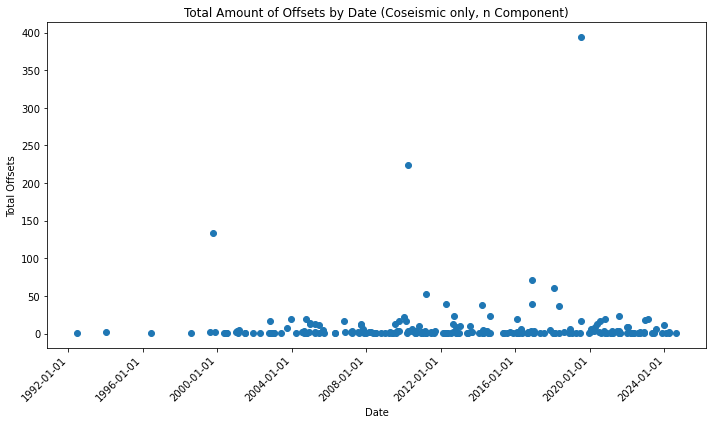

In [163]:
plot_offsets_by_date(dfs, 'n', coseismic_only=True)

In [164]:
def plot_offsets_per_station(dfs, component, coseismic_only=True):
    offset_counts = []

    for df in dfs:
        count = 0
        for offset in df.attrs['offsets'][component]['offsets']:
            if coseismic_only and not offset['coseismic']:
                continue
            count += 1
        offset_counts.append(count)

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(offset_counts)), offset_counts)

    plt.title('Total Number of Offsets per Station' + (f' (Coseismic only, {component} Component)' if coseismic_only else f' ({component} Component)'))
    plt.xlabel('Stations')
    plt.ylabel('Number of Offsets')

    plt.tight_layout()
    plt.show()

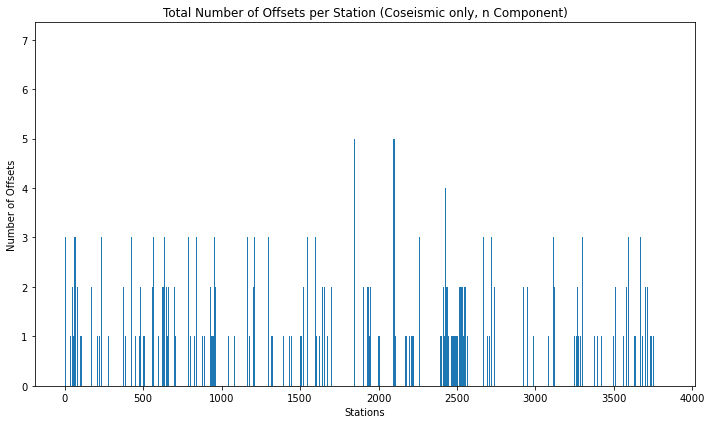

In [165]:
plot_offsets_per_station(dfs, 'n', coseismic_only=True)

In [166]:
def add_missing_dates(df):
    df.index = pd.to_datetime(df.index)
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df_full = df.reindex(full_date_range)
    df_full.name = df.name
    return df_full

In [167]:
def plot_unobserved_days(dfs, comp, fill_missing_dates=True):
    # if fill_missing_dates: Count None values if we add them for every unboserved day between the first and last entry
    none_counts = []

    for df in dfs:
        if fill_missing_dates:
            df_full = add_missing_dates(df)
            none_count = df_full[comp].isna().sum()
        else:
            none_count = df[comp].isna().sum()
        
        none_counts.append(none_count)

    plt.figure(figsize=(10, 6))
    if fill_missing_dates:
        plt.bar(range(len(none_counts)), none_counts)
    else:
        plt.scatter(range(len(none_counts)), none_counts)

    plt.title(f'Number of Unobserved Days for {comp} Component Across Stations ' + ('(filled missing dates)' if fill_missing_dates else ''))
    plt.xlabel('Stations')
    plt.ylabel(f'Count of None Values in {comp} Component')
    plt.tight_layout()
    plt.show()
    print('The total number of unobserved days is' + (' (filled missing dates): ' if fill_missing_dates else ': ') + str(sum(none_counts)))

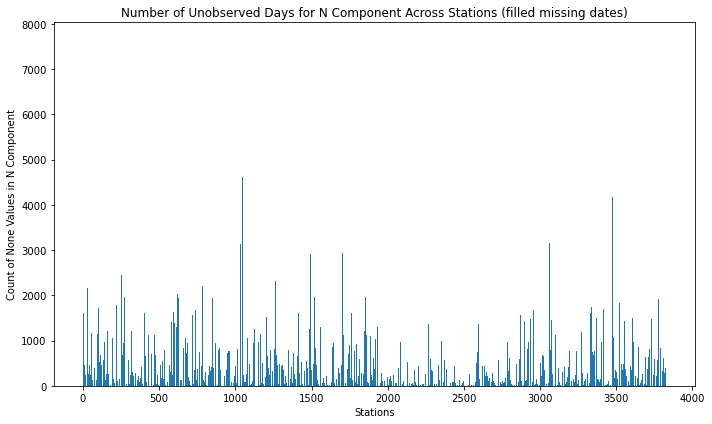

The total number of unobserved days is (filled missing dates): 1887528


In [168]:
plot_unobserved_days(dfs, 'N', fill_missing_dates=True)

In [175]:
# Data cleaning: Only select stations that have a coseismic offset
# Delete the non-coseismic offsets
# Look at the None values: How many stations do we lose if we remove all time series with x% missing values
# Baseline (CHOW test)
# Machine learning implementation: XGBoost, Isolated Forest, perhaps the same implementation that Laura used

df.attrs

{'geometry': <shapely.geometry.point.Point at 0x25dafa97f40>,
 'height': 412.7631,
 'offsets': {'n': {'offsets': [], 'ps_decays': []},
  'e': {'offsets': [], 'ps_decays': []},
  'u': {'offsets': [], 'ps_decays': []}}}

In [170]:
def clean_dataframes(dfs, missing_value_threshold=None):
    """
    Cleans the dataframes by:
    1. Removing dataframes without any coseismic offsets in any of the 3 components (n, e, u).
    2. Removing non-coseismic offsets from all components.
    3. Optionally removing dataframes with excessive missing values in all 3 components.

    Parameters:
    dfs (list): List of dataframes with GNSS data.
    missing_value_threshold (float, optional): Percentage (0 to 1) of allowed missing values.
                                               If exceeded, the dataframe is removed.

    Returns:
    list: Cleaned list of dataframes.
    """

    cleaned_dfs = []
    components = ['N', 'E', 'U']
    components_offsets = ['n', 'e', 'u']

    for org_df in dfs:
        
        has_coseismic = False
        df = add_missing_dates(org_df)

        for comp in components_offsets:
            filtered_offsets = []
            for offset in df.attrs['offsets'][comp]['offsets']:
                if offset['coseismic']:
                    has_coseismic = True
                    filtered_offsets.append(offset)
            # Update offsets to retain only coseismic
            df.attrs['offsets'][comp]['offsets'] = filtered_offsets

        # Skip dataframe if no coseismic offsets in any component
        if not has_coseismic:
            continue

        # Check missing values for all components combined, if threshold is provided
        if missing_value_threshold is not None:
            total_values = sum(df[comp].size for comp in components)
            missing_values = sum(df[comp].isna().sum() for comp in components)

            missing_percentage = missing_values / total_values
            if missing_percentage > missing_value_threshold:
                continue  # Skip the dataframe if missing values exceed the threshold

        # Add the cleaned dataframe to the list
        cleaned_dfs.append(df)

    return cleaned_dfs


In [171]:
cleaned_dfs = clean_dataframes(dfs, missing_value_threshold=0.2)

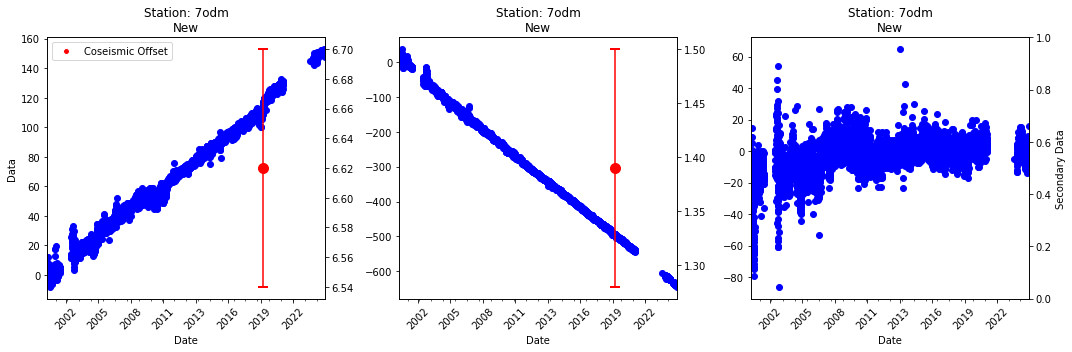

In [173]:
plot_time_series(cleaned_dfs[0], cols=['N', 'E', 'U'], titles=['New', 'New', 'New'])